# PSNR vs Loss analysis

In [1]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

## Load data
Customize `NPZ_FILE_PATH` variable to `{path/to/experiment/output_folder}/psnrx/psnr_expert_hist.npz`

In [2]:
# input

NPZ_FILE_PATH = "/gpfs/work5/0/prjs0799/saved_expert_output/Replica/expP_office0/psnr_expert/office0/2024-12-10T11:18:29.497952 with vis/psnrx/psnr_expert_hist.npz"

In [3]:
# load data

data = np.load(NPZ_FILE_PATH, allow_pickle=True)
"""
Original save code:
np.savez(os.path.join(dir_path, "psnr_expert_hist.npz"),
        timestamp_hist=self.timestamp_hist,  # list of float/ints
        gt_pose_hist=self.gt_pose_hist,  # list of np.array (7,)
        x1_pose_hist=self.x1_pose_hist,
        x2_pose_hist=self.x2_pose_hist,
        x3_pose_hist=self.x3_pose_hist,
        x4_pose_hist=self.x4_pose_hist,
        x5_pose_hist=self.x5_pose_hist,
        x1_psnr_hist=self.x1_psnr_hist,  # list of floats
        x2_psnr_hist=self.x2_psnr_hist,
        x3_psnr_hist=self.x3_psnr_hist,
        x4_psnr_hist=self.x4_psnr_hist,
        x5_psnr_hist=self.x5_psnr_hist,
        x1_loss_hist=self.x1_loss_hist,  # list of floats
        x2_loss_hist=self.x2_loss_hist,
        x3_loss_hist=self.x3_loss_hist,
        x4_loss_hist=self.x4_loss_hist,
        x5_loss_hist=self.x5_loss_hist)
"""
data = {k: np.array(data[k]) for k in data.files}
# fix torch tensors
for k in data:
    if isinstance(data[k][0], torch.Tensor):
        data[k] = np.array([x.cpu().numpy() for x in data[k]])

In [4]:
# show data

for k in data:
    print(k, data[k].shape, data[k].dtype)

timestamp_hist (1999,) int64
gt_pose_hist (1999, 7) float32
x1_pose_hist (1999, 7) float32
x2_pose_hist (1999, 7) float32
x3_pose_hist (1999, 7) float32
x4_pose_hist (1999, 7) float32
x5_pose_hist (1999, 7) float32
x1_psnr_hist (1999,) float64
x2_psnr_hist (1999,) float64
x3_psnr_hist (1999,) float64
x4_psnr_hist (1999,) float64
x5_psnr_hist (1999,) float64
x1_loss_hist (1999,) float64
x2_loss_hist (1999,) float64
x3_loss_hist (1999,) float64
x4_loss_hist (1999,) float64
x5_loss_hist (1999,) float64


In [5]:
# create dataframe

t = np.array(data['timestamp_hist'])
experts = ['x1', 'x2', 'x3', 'x4', 'x5']
psnr = np.stack([data[f'{e}_psnr_hist'] for e in experts], axis=1)
loss = np.stack([data[f'{e}_loss_hist'] for e in experts], axis=1)

df_data = []
for i in range(len(t)):
    df_data.extend([{
        't': int(t[i]),
        'expert': int(e[1]),
        'psnr': float(data[f'{e}_psnr_hist'][i]),
        'loss': float(data[f'{e}_loss_hist'][i]),
        } for e in experts])
    
df = pd.DataFrame(df_data)

# 1999 * 5 = 9995
df

,t,expert,psnr,loss
0,1,1,31.399757,0.011755
1,1,2,30.226505,0.030503
2,1,3,30.009483,0.026936
3,1,4,30.198738,0.029145
4,1,5,29.928339,0.033052
...,...,...,...,...
9990,1999,1,20.946796,0.109851
9991,1999,2,26.676826,0.102647
9992,1999,3,26.350355,0.111363
9993,1999,4,31.060017,0.014430


## PSNR-vs-loss correlation plots

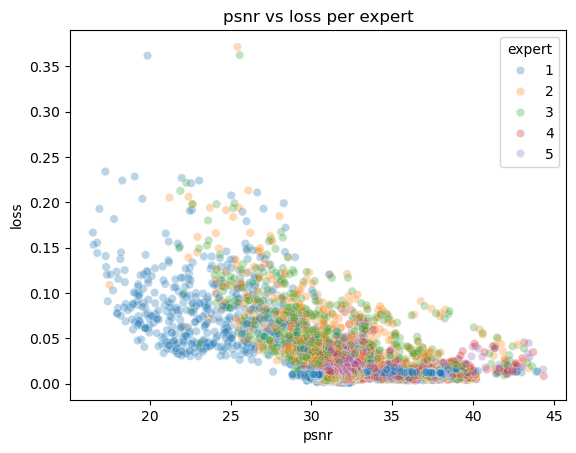

In [6]:
plt.title('psnr vs loss per expert')
sns.scatterplot(data=df, x='psnr', y='loss', hue='expert', palette='tab10', alpha=0.3)
plt.show()

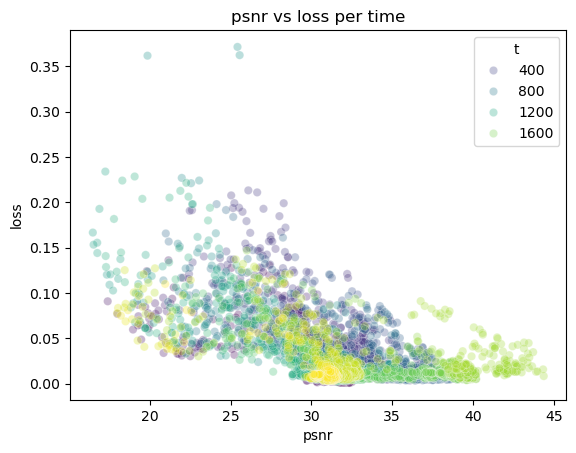

In [7]:
plt.title('psnr vs loss per time')
sns.scatterplot(data=df, x='psnr', y='loss', hue='t', palette='viridis', alpha=0.3)
plt.show()

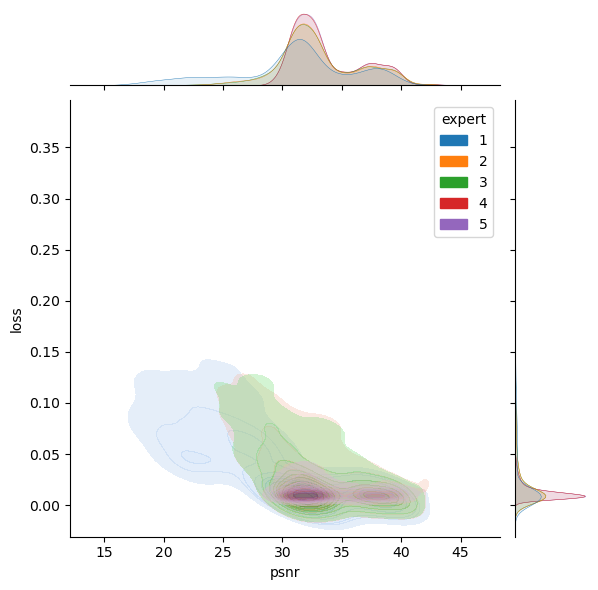

In [8]:
sns.jointplot(data=df, x='psnr', y='loss', hue='expert', kind='kde', fill=True, common_norm=False, palette='tab10',
                alpha=0.3, marginal_kws={'alpha': 0.1, 'linewidth': 0.3})
plt.show()

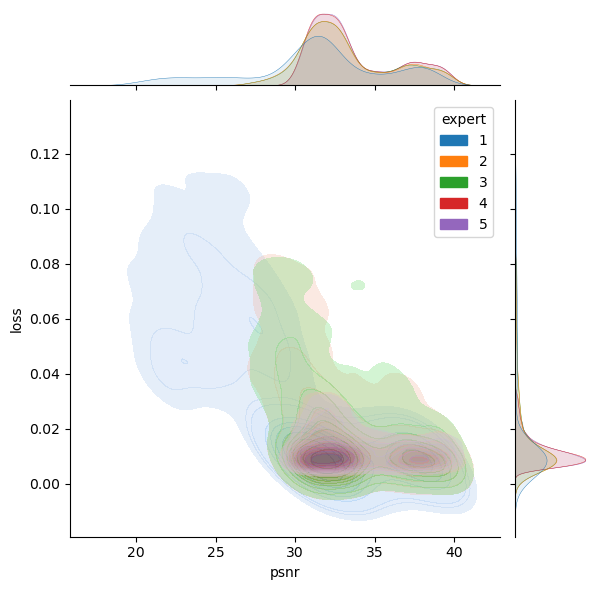

In [9]:
# removing outliers
q = 0.03
df2 = df.copy()
for e in experts:
    q1 = df2[df2['expert'] == int(e[1])]['psnr'].quantile(q)
    q2 = df2[df2['expert'] == int(e[1])]['psnr'].quantile(1-q)
    df2 = df2[(df2['expert'] != int(e[1])) | (df2['psnr'] >= q1) & (df2['psnr'] <= q2)]
    q1 = df2[df2['expert'] == int(e[1])]['loss'].quantile(q)
    q2 = df2[df2['expert'] == int(e[1])]['loss'].quantile(1-q)
    df2 = df2[(df2['expert'] != int(e[1])) | (df2['loss'] >= q1) & (df2['loss'] <= q2)]

# sns.kdeplot(data=df2, x='psnr', y='loss', hue='expert', fill=True, common_norm=False, alpha=0.3, palette='tab10')
# plt.show()

sns.jointplot(data=df2, x='psnr', y='loss', hue='expert', kind='kde', fill=True, common_norm=False, palette='tab10',
                alpha=0.3, marginal_kws={'alpha': 0.1, 'linewidth': 0.3})
plt.show()

In [10]:
# compute centroids
centroids = []
for e in experts:
    # # psnr and loss values at peak of the distribution
    # peak_psnr = df2[df2['expert'] == int(e[1])].groupby('t')['psnr'].mean().max()
    # peak_loss = df2[df2['expert'] == int(e[1])].groupby('t')['loss'].mean().min()
    # print('Expert', e[1], 'peak psnr:', peak_psnr, 'peak loss:', peak_loss)
    # centroids.append((peak_psnr, peak_loss))

    mean_psnr = df2[df2['expert'] == int(e[1])]['psnr'].mean()
    mean_loss = df2[df2['expert'] == int(e[1])]['loss'].mean()
    print('Expert', e[1], 'mean psnr:', mean_psnr, 'mean loss:', mean_loss)
    centroids.append((mean_psnr, mean_loss))

def add_centroids(df):
    for i, (x, y) in enumerate(centroids):
        plt.scatter(x, y, color=f'C{i}', label=f'expert {i+1}', s=20, marker='x')

Expert 1 mean psnr: 31.29959493426358 mean loss: 0.0214402071593419
Expert 2 mean psnr: 33.183496388767665 mean loss: 0.017097057389206236
Expert 3 mean psnr: 33.18900636991766 mean loss: 0.017197616888795883
Expert 4 mean psnr: 33.63961597907307 mean loss: 0.011809235361929741
Expert 5 mean psnr: 33.66463938380774 mean loss: 0.01176627973047093


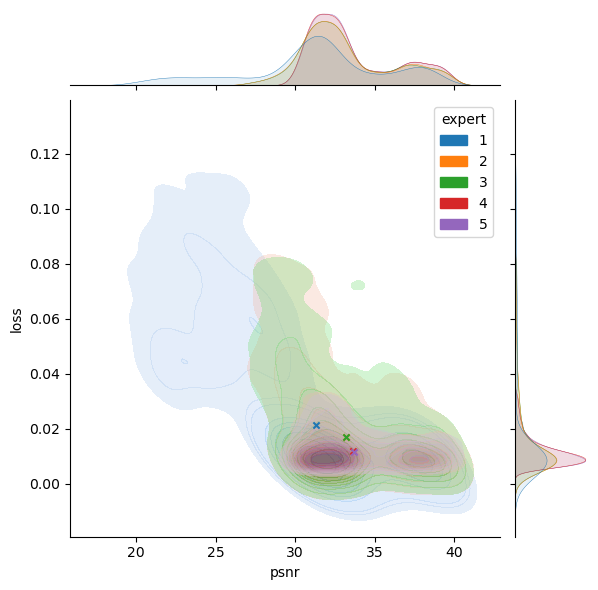

In [11]:
# plot with centroids
sns.jointplot(data=df2, x='psnr', y='loss', hue='expert', kind='kde', fill=True, common_norm=False, palette='tab10',
                alpha=0.3, marginal_kws={'alpha': 0.1, 'linewidth': 0.3})
add_centroids(df2)
plt.show()

In [12]:
# global mean and std in psnr and loss
mean_psnr = df['psnr'].mean()
std_psnr = df['psnr'].std()
mean_loss = df['loss'].mean()
std_loss = df['loss'].std()
median_psnr = df['psnr'].median()
median_loss = df['loss'].median()

print(f'psnr={mean_psnr:.4f}±{std_psnr:.4f}, median={median_psnr:.4f}')
print(f'loss={mean_loss:.4f}±{std_loss:.4f}, median={median_loss:.4f}')

psnr=32.8901±3.8112, median=32.3125
loss=0.0194±0.0261, median=0.0102


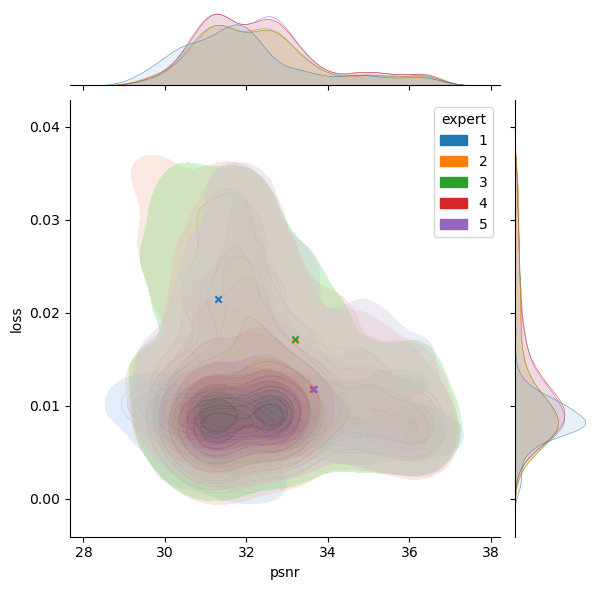

In [13]:
psnr_lim = (mean_psnr - std_psnr, mean_psnr + std_psnr)
loss_lim = (median_loss - std_loss, median_loss + std_loss)
df_lim = df[(df['psnr'] > psnr_lim[0]) & (df['psnr'] < psnr_lim[1]) & (df['loss'] > loss_lim[0]) & (df['loss'] < loss_lim[1])]

sns.jointplot(data=df_lim, x='psnr', y='loss', hue='expert', kind='kde', fill=True, common_norm=False, palette='tab10',
                alpha=0.3, marginal_kws={'alpha': 0.1, 'linewidth': 0.3})
add_centroids(df_lim)
plt.show()

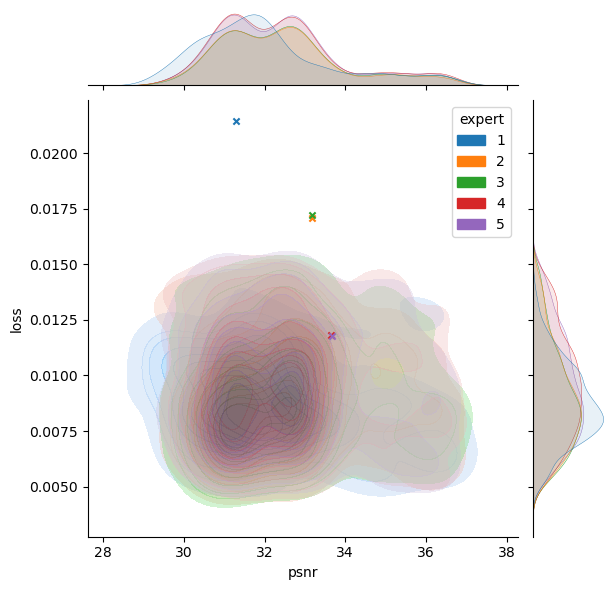

In [14]:
psnr_lim = (mean_psnr - std_psnr, mean_psnr + std_psnr)
loss_lim = (0.005, 0.015)
df_lim = df[(df['psnr'] > psnr_lim[0]) & (df['psnr'] < psnr_lim[1]) & (df['loss'] > loss_lim[0]) & (df['loss'] < loss_lim[1])]

sns.jointplot(data=df_lim, x='psnr', y='loss', hue='expert', kind='kde', fill=True, common_norm=False, palette='tab10',
                alpha=0.3, marginal_kws={'alpha': 0.1, 'linewidth': 0.3})
add_centroids(df_lim)
plt.show()

## Expert ranking

In [15]:
rank = df.groupby('expert')[['psnr', 'loss']].mean()
rank.sort_values(by='psnr', ascending=False).rename(columns={'psnr': 'avg_psnr (↑)', 'loss': 'avg_loss'}).reset_index().reset_index().rename(columns={'index': 'rank_psnr (↓)'}).groupby('rank_psnr (↓)').first().sort_values(by='rank_psnr (↓)')

,expert,avg_psnr (↑),avg_loss
rank_psnr (↓),,,
0,5,33.715989,0.012769
1,4,33.700274,0.012880
2,3,33.028906,0.022268
3,2,33.023701,0.022281
4,1,30.981773,0.026917


In [16]:
rank.sort_values(by='loss', ascending=True).rename(columns={'psnr': 'avg_psnr', 'loss': 'avg_loss (↓)'}).reset_index().reset_index().rename(columns={'index': 'rank_loss (↓)'}).groupby('rank_loss (↓)').first().sort_values(by='rank_loss (↓)')

,expert,avg_psnr,avg_loss (↓)
rank_loss (↓),,,
0,5,33.715989,0.012769
1,4,33.700274,0.012880
2,3,33.028906,0.022268
3,2,33.023701,0.022281
4,1,30.981773,0.026917


## Classification metrics for selected expert

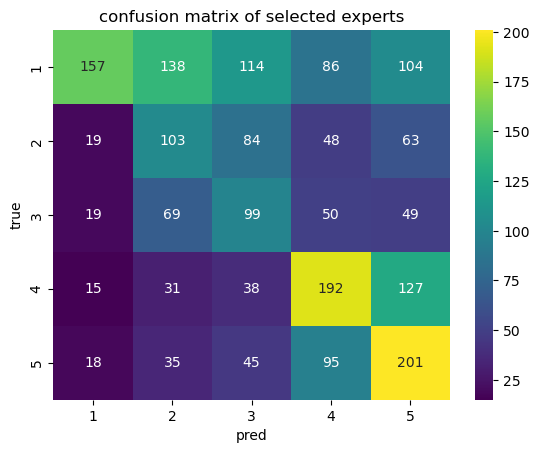

In [ ]:
# confusion matrix

pred = df.groupby('t')['psnr'].idxmax().apply(lambda x: df.loc[x, 'expert'])
true = df.groupby('t')['loss'].idxmin().apply(lambda x: df.loc[x, 'expert'])

confusion = pd.crosstab(true, pred, rownames=['true'], colnames=['pred'])

plt.title('confusion matrix')
sns.heatmap(confusion, annot=True, fmt='d', cmap='viridis')
plt.show()

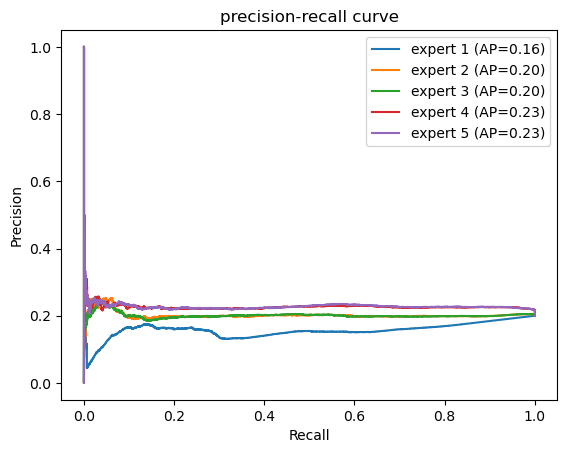

In [ ]:
# precision-recall curves

# one-vs-all
for e in experts:
    y_true = (df['expert'] == int(e[1])).astype(int)
    y_score = df['psnr']
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(recall, precision, label=f'expert {e[1]} (AP={ap:.2f})')

plt.title('precision-recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()